In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
from pathlib import Path
import re
from rasterio.features import shapes
import shapely
import xarray as xr
import rioxarray as rxr

In [2]:
PARENT_DIR = Path("/home/iborlafm/Downloads/Mozambique")

path_pairs = {
    "wcover": PARENT_DIR / "ESA_WorldCover_30m_2020_v100_Maputo_Map.tif",
    "glad": PARENT_DIR / "lc_glad.glcluc_c_30m_s_20200101_20201231_go_UTM36N_v20230901.tif",
}

In [3]:
array_pairs = {}
for cover_name, cover_path in path_pairs.items():

    array_pairs[cover_name] = (
        xr.open_dataset(cover_path)
        .sel(band=1)["band_data"].rename(cover_name)
        )

In [4]:
full_frame = xr.Dataset(array_pairs).drop_vars(["band", "spatial_ref"]).to_dataframe().dropna().astype(int)

In [5]:
count_frame = (
    full_frame.groupby(["wcover", "glad"]).size().reset_index(name="count")
    )

In [6]:
sel_frame = count_frame.sort_values("count", ascending=False).groupby("wcover").head(5)

In [7]:
glad_pairs = {}

with open(PARENT_DIR / "color.clr") as color_txt:

    for line in color_txt.readlines():

        split_tail = line.strip().split(" ")[5:]
        glad_pairs[int(split_tail[-1][1:-1])] = joined_tail = " ".join(split_tail)

In [8]:
name_frame = pd.Series(glad_pairs, name="glad_names").to_frame().reset_index(names="glad")

In [9]:
sorted_frame = sel_frame.merge(name_frame).sort_values(["wcover", "glad"])

In [10]:
sorted_frame.to_excel(PARENT_DIR / "manual_raw.xlsx")

In [11]:
manual_frame = pd.read_excel(PARENT_DIR / "manual_edited.xlsx", index_col=0).drop(columns=["count", "glad_names"])

In [12]:
labeled_frame = (
    full_frame.reset_index()
    .merge(manual_frame, how="left")
    .set_index(["y", "x"])
    .fillna(0)
    .astype(np.uint8)
    )

In [13]:
patches = labeled_frame.to_xarray()["manual"].sortby("y", ascending=False)

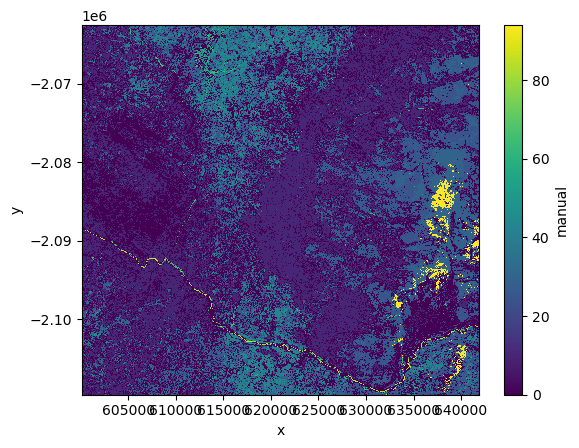

In [14]:
patches.plot.imshow()

In [15]:
polygon_pile, value_pile = [], []
for poly, value in shapes(patches, transform=array_pairs["glad"].rio.transform()):

    polygon_pile.append(shapely.Polygon(poly["coordinates"][0]))
    value_pile.append(value)

In [16]:
poly

{'type': 'Polygon',
 'coordinates': [[(641820.0, -2109630.0),
   (641820.0, -2109660.0),
   (641850.0, -2109660.0),
   (641850.0, -2109630.0),
   (641820.0, -2109630.0)]]}

In [17]:
all_polygons = gpd.GeoDataFrame({"label": value_pile}, geometry=polygon_pile, crs=array_pairs["glad"].rio.crs)
all_polygons["area"] = all_polygons["geometry"].area

all_polygons.sort_values("area", ascending=False, inplace=True)

large_polygons = all_polygons[(all_polygons["area"] > 4500) & (all_polygons["label"] != 0)]

In [18]:
head_polygons = large_polygons.groupby("label").head(2)

In [19]:
head_polygons

,label,geometry,area
109295,10.0,"POLYGON ((628860 -2062500, 628860 -2062530, 62...",144158400.0
198109,10.0,"POLYGON ((624210 -2075160, 624210 -2075250, 62...",125523000.0
150420,30.0,"POLYGON ((637350 -2078040, 637350 -2078070, 63...",24832800.0
98768,24.0,"POLYGON ((639840 -2073540, 639840 -2073660, 63...",8710200.0
67031,44.0,"POLYGON ((616800 -2066700, 616800 -2066820, 61...",8286300.0
166269,24.0,"POLYGON ((634980 -2087790, 634980 -2087880, 63...",7695000.0
169570,30.0,"POLYGON ((639960 -2087610, 639960 -2087640, 63...",6924600.0
139816,94.0,"POLYGON ((638310 -2082120, 638310 -2082240, 63...",5053500.0
25659,44.0,"POLYGON ((620760 -2062500, 620760 -2062530, 62...",3584700.0
40725,50.0,"POLYGON ((613170 -2065320, 613170 -2065380, 61...",1349100.0


In [20]:
head_polygons.to_file(PARENT_DIR / "head_polys.geojson")